<a href="https://colab.research.google.com/github/SVeldman/ml_final_spring_2024/blob/main/ml_final_skin_cancer_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Supervised Machine Learning Approach for Skin Cancer Detection with Convolutional Neural Networks

Steve Veldman -
5/10/24 -
ADSP 31009

In [ ]:
#pip install split-folders
#pip install --upgrade keras-cv tensorflow
#!pip install --upgrade keras


In [1]:
import numpy as np
import tensorflow as tf
import sklearn
import pandas as pd
#import splitfolders
import keras_cv
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import os
import shutil
import random
import PIL
from PIL import Image

from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, InputLayer
from keras.layers import RandomCrop, RandomFlip, RandomRotation, RandomZoom, RandomContrast, Rescaling
from keras_cv.layers import Resizing
from keras.utils import plot_model
#from tensorflow.keras.layers import InputLayer

from tqdm.keras import TqdmCallback
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization

#I. Load and Organize Data

In [ ]:
# Import metadata
metadata = pd.read_csv("HAM10000_metadata_sorted.csv", header=0)

# Add benign/malignant status
status = []
for index in metadata.index:
    if metadata.dx[index] in ['nv', 'bkl', 'vasc', 'df']:
        status.append('benign')
    else:
        status.append('malignant')
metadata['status'] = status

metadata.head()

lesion_id      image_id   dx    dx_type   age     sex     localization  \
0  HAM_0000550  ISIC_0024306   nv  follow_up  45.0    male            trunk   
1  HAM_0003577  ISIC_0024307   nv  follow_up  50.0    male  lower extremity   
2  HAM_0001477  ISIC_0024308   nv  follow_up  55.0  female            trunk   
3  HAM_0000484  ISIC_0024309   nv  follow_up  40.0    male            trunk   
4  HAM_0003350  ISIC_0024310  mel      histo  60.0    male            chest   

         dataset     status  
0  vidir_molemax     benign  
1  vidir_molemax     benign  
2  vidir_molemax     benign  
3  vidir_molemax     benign  
4   vidir_modern  malignant

In [ ]:
# helper code for organizing images into various directories:
'''
source = '/content/7'
list = os.listdir(source)
dst = '/content/HAM10000_images_part_7'

for image in list:
  src = os.path.join(source, image)

  #the destination path
  #dst = os.path.join(HAM10000_images_part_2+'/'+image)

  shutil.move(src, dst)
'''

In [ ]:
# Code to organize images from HAM10000 into class subfolders (credit - modified from: https://gist.github.com/tampapath/0534e312eee7aeb499c4e025e230c0e1)

# Make base directory
images = 'HAM10000_images'
os.mkdir(images)

# Create list of image classes
image_class = ['nv','mel','bkl','bcc','akiec','vasc','df']

# Make class sub-directories
for x in image_class:
        os.mkdir(images+'/'+x)

# Get a list of images in each of the two HAM10000 downloaded folders
folder_1 = os.listdir('/content/HAM10000_images_part_1')
folder_2 = os.listdir('/content/HAM10000_images_part_2')

# Assign an index column image_id to pandas dataframe
metadata = metadata.set_index('image_id', drop = False)

# Get a list of image file names from .cvs file
image_list = list(metadata['image_id'])

# Transfer the images from two uploaded directories into class sub-directories
for image in image_list:
    fname = image + '.jpg'

    if fname in folder_1:

        #the source path
        src = os.path.join('HAM10000_images_part_1', fname)

        #the destination path
        dst = os.path.join(images+'/'+metadata['dx'][image], fname)

        shutil.move(src, dst)

    if fname in folder_2:

        #the source path
        src = os.path.join('HAM10000_images_part_2', fname)

        #the destination path
        dst = os.path.join(images+'/'+metadata['dx'][image], fname)

        shutil.move(src, dst)

In [ ]:
images_path = '/content/HAM10000_images'
(train, validate) = keras.utils.image_dataset_from_directory(
    images_path,
    labels="inferred",
    label_mode="categorical",
    class_names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
    color_mode="rgb",
    batch_size=32,
    image_size=(450, 600),
    shuffle=True,
    seed=47,
    validation_split=0.2,
    subset='both',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)

Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Using 2003 files for validation.


#II. Explore Data

In [ ]:
# Function to plot sample images with labels:
def plot_random_images_from_classes(directory, n_images=3):
    """
    Plots n_images random images from each class in the directory.

    Args:
        directory (str): Path to the directory containing class subdirectories.
        n_images (int): Number of random images to sample from each class.
    """
    classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    n_classes = len(classes)
    fig, axs = plt.subplots(n_images, n_classes, figsize=(n_classes*3, n_images*3))

    for i, class_name in enumerate(classes):
        class_path = os.path.join(directory, class_name)
        images = [img for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
        sampled_images = random.sample(images, n_images)

        for j, img_name in enumerate(sampled_images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            axs[j, i].imshow(img)
            axs[j, i].axis('off')
            if j == 0:
                axs[j, i].set_title(class_name, fontsize=24)

    plt.tight_layout()
    plt.show()

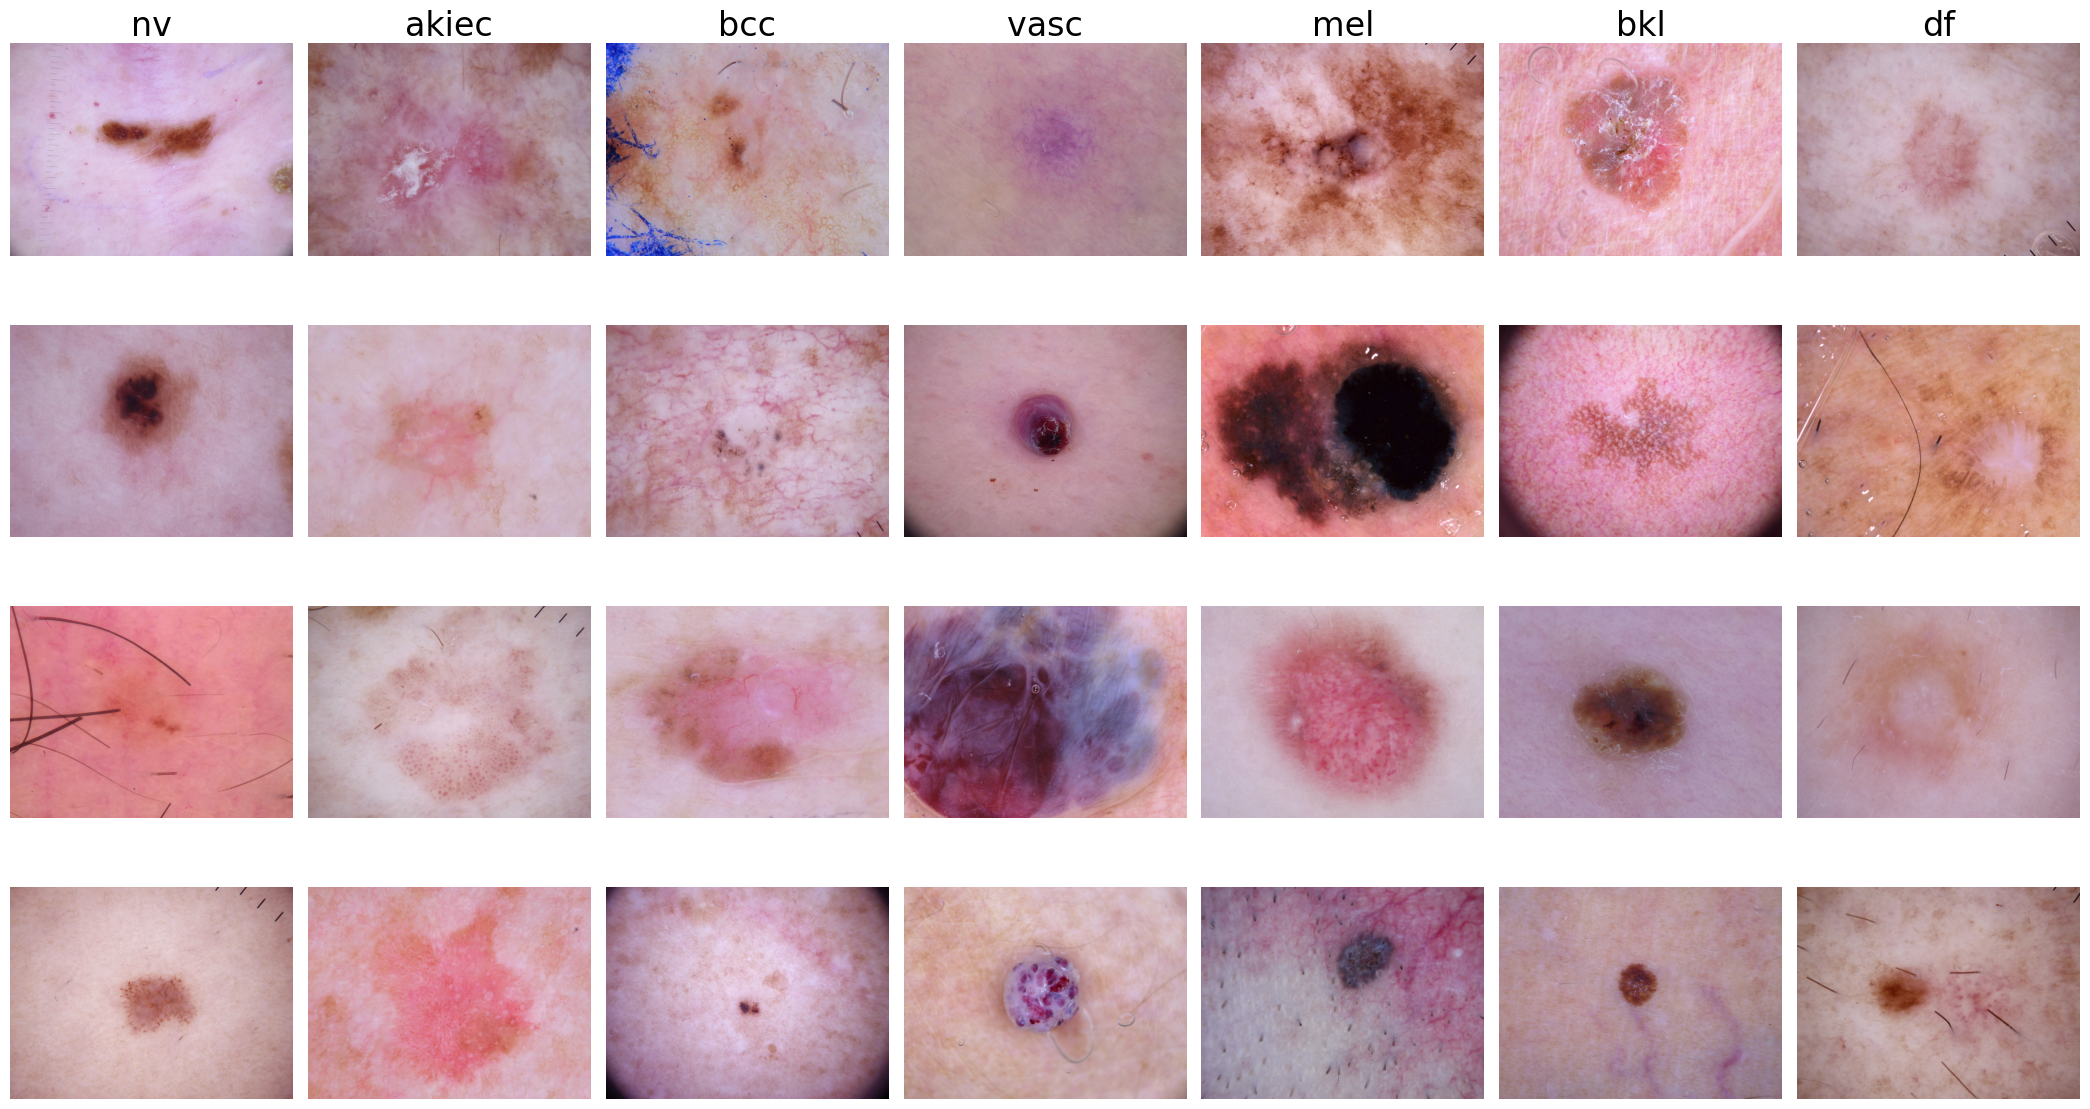

In [ ]:
plot_random_images_from_classes('/content/HAM10000_images', n_images = 4)

In [ ]:
# Verify batch size, image shape, and class names for training data:
for images, labels in train:
    print(images.shape)
    break

print(train.class_names)

(32, 450, 600, 3)
['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
# Verify batch size, image shape, and class names for validation data:
for images, labels in validate:
    print(images.shape)
    break

print(validate.class_names)

(32, 450, 600, 3)
['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
# Examine metadata:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


<Figure size 1700x1000 with 0 Axes>

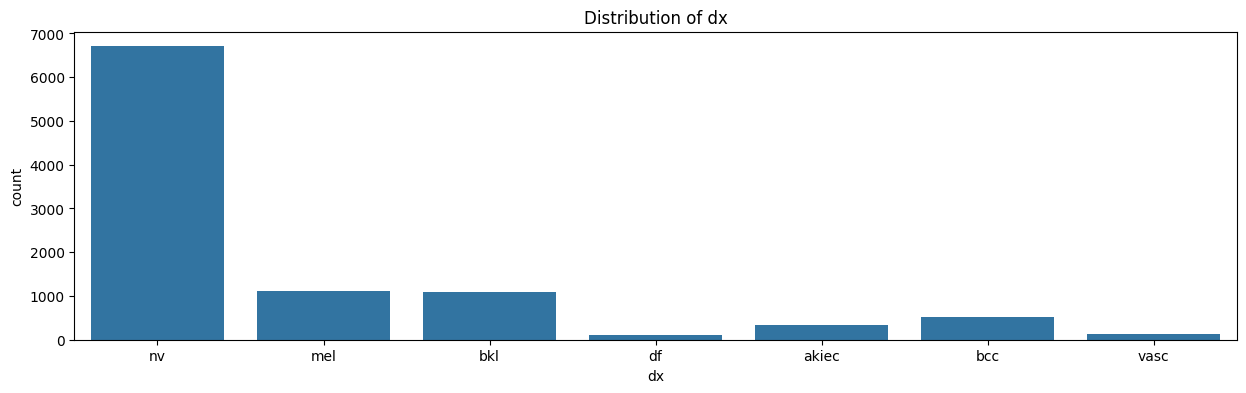

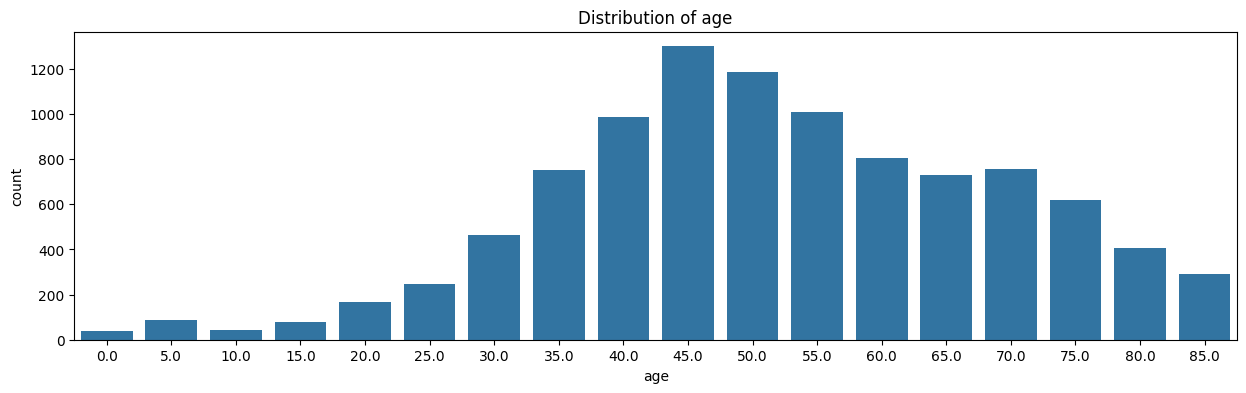

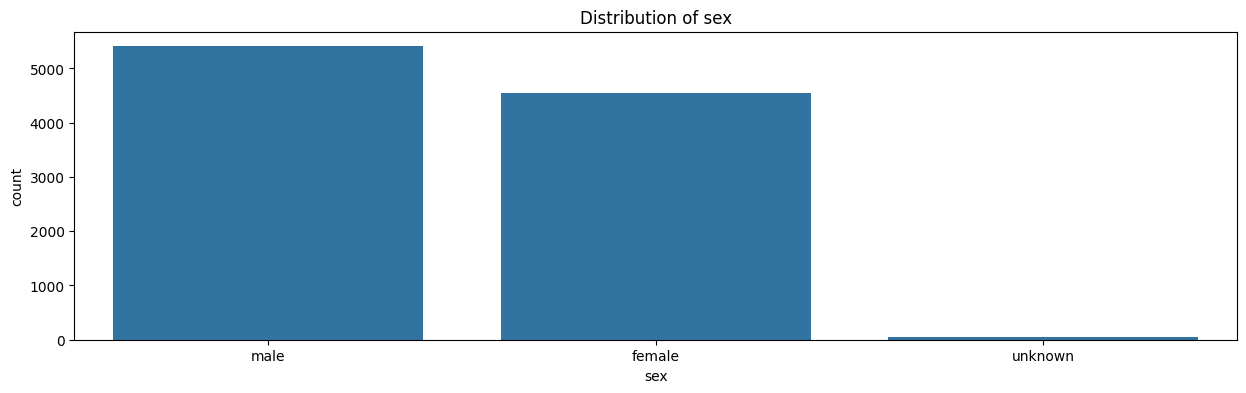

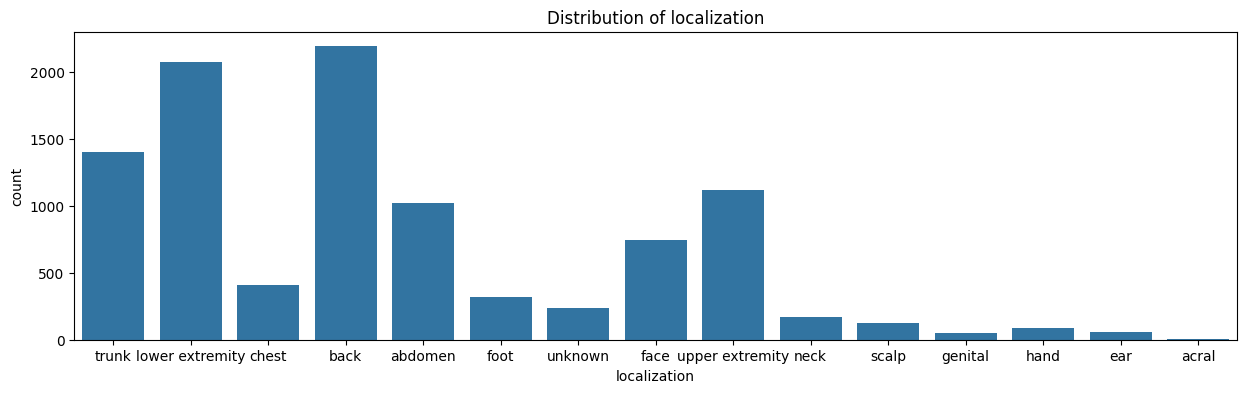

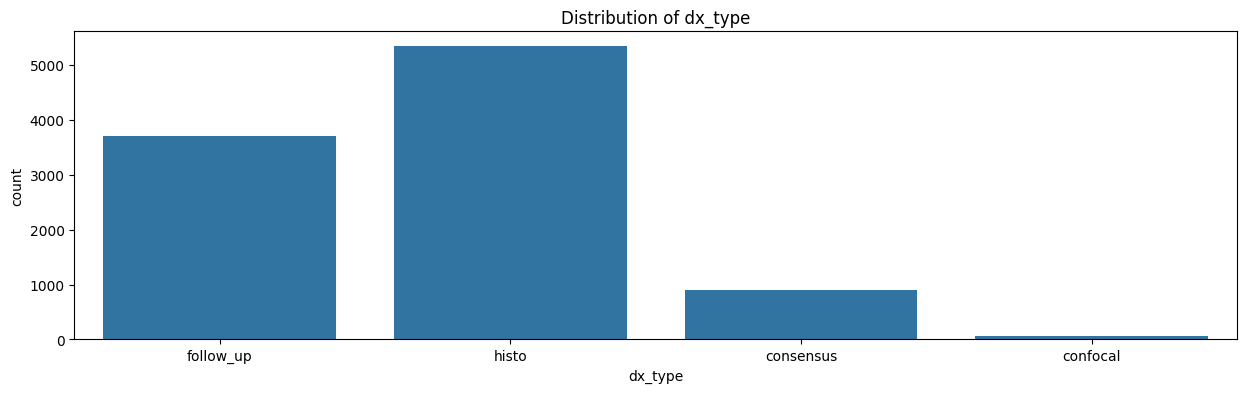

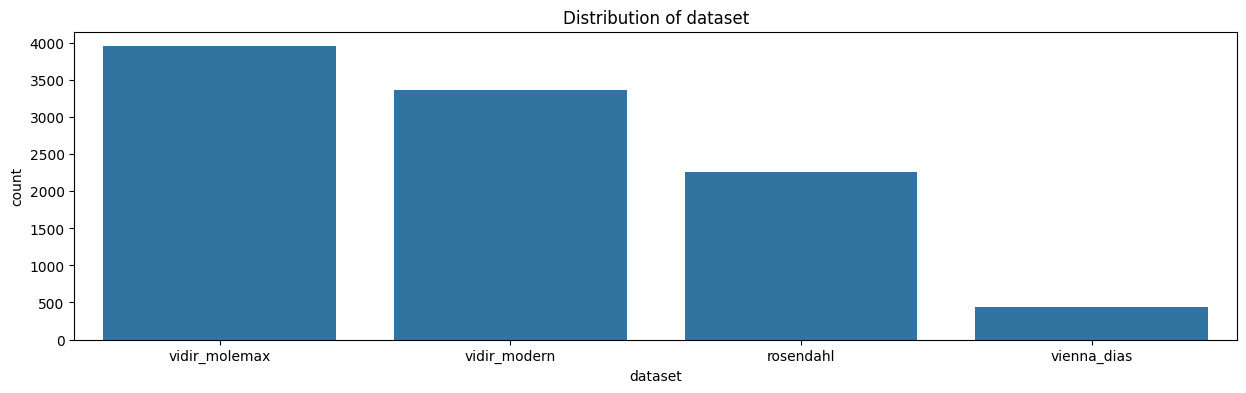

In [ ]:
# Plot distributions of metadata of interest:
plt.figure(figsize=(17,10))

cols_to_plot = ['dx', 'age', 'sex', 'localization', 'dx_type', 'dataset']

for col in  cols_to_plot:
    plt.figure(figsize=(15, 4))
    sns.countplot(x=metadata[col])
    plt.title(f'Distribution of {col}')
    plt.show()

#III. Import Test Data

In [3]:
test_metadata = pd.read_csv('/content/ISIC2018_Task3_Test_GroundTruth.csv')

In [7]:
# Code to organize test images into class subfolders (credit - modified from: https://gist.github.com/tampapath/0534e312eee7aeb499c4e025e230c0e1)

# Make base directory
images = 'Test_Images'
os.mkdir(images)

# Create list of image classes
image_class = ['nv','mel','bkl','bcc','akiec','vasc','df']

# Make class sub-directories
for x in image_class:
        os.mkdir(images+'/'+x)

# Get a list of images in test dataset
test_list = os.listdir('/content/ISIC2018_Task3_Test_Images')

# Assign an index column image_id to pandas dataframe
test_metadata = test_metadata.set_index('image_id', drop = False)

# Get a list of image file names from .cvs file
image_list = list(test_metadata['image_id'])

# Transfer the images from two uploaded directories into class sub-directories
for image in image_list:
  try:
      fname = image + '.jpg'

      src = os.path.join('/content/ISIC2018_Task3_Test_Images', fname)

          #the destination path
      dst = os.path.join(images+'/'+test_metadata['dx'][image], fname)

      shutil.move(src, dst)
  except FileNotFoundError:
      pass

In [111]:
test_images_path = '/content/Test_Images'
(test) = keras.utils.image_dataset_from_directory(
    test_images_path,
    labels="inferred",
    label_mode="categorical",
    class_names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
    color_mode="rgb",
    batch_size=32,
    image_size=(450, 600),
    shuffle=False,
    seed=47,
    #validation_split=0.2,
    #subset='both',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    #pad_to_aspect_ratio=False,
    #data_format=None,
    #verbose=True,
)

Found 1511 files belonging to 7 classes.


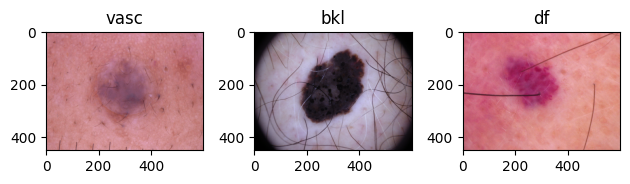

In [ ]:
# Print example images from test set:
for images, labels in test:
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(image_class[labels[i].numpy().argmax()])
        #plt.xlabel(labels[i].numpy().astype("uint8"))
        plt.tight_layout()

# IV. Build and Train CNN Model From Scratch



In [ ]:
# Establish Resize/Rescale and Data Augmentation layers:
resize_and_rescale = tf.keras.Sequential([Resizing(225, 300), Rescaling(1./255)])

data_augmentation = tf.keras.Sequential()
data_augmentation.add(RandomFlip())
data_augmentation.add(RandomRotation(factor=(-0.5, 0.5)))
data_augmentation.add(RandomZoom(height_factor=(-0.2, 0.2)))
data_augmentation.add(RandomContrast(factor=(.2)))
#data_augmentation.add(RandomBrightness(factor=(-0.2, 0.2)))
#data_augmentation.add(RandomShear(0.2))

The following built-from-scrath model (saved/denoted as "model_scratch") performed the best out of the many alternate architectures evaluated. The output of the training cells below demonstrate its continued improvement between 10 and 30 epochs of training. The model was then trained an additional 10 epochs, for a total of 40. The visual output of that training run was unfortunately not presereved, but results were saved and have be re-loaded in order to compare performance with the 30-epoch version.

In [ ]:
model_scratch = Sequential()

#add data augmentation layers (only active during training):
model_scratch.add(resize_and_rescale)
model_scratch.add(data_augmentation)

#build model layers
model_scratch.add(Conv2D(128, (3, 3), padding = 'same', input_shape=(225, 300, 3)))
model_scratch.add(Activation('relu'))
model_scratch.add(BatchNormalization())
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(128, (3, 3)))
model_scratch.add(Activation('relu'))
model_scratch.add(BatchNormalization())
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(128, (3, 3)))
model_scratch.add(Activation('relu'))
model_scratch.add(BatchNormalization())
model_scratch.add(Conv2D(128, (3, 3)))
model_scratch.add(Activation('relu'))
model_scratch.add(BatchNormalization())
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Dropout(0.5))

model_scratch.add(Conv2D(128, (3, 3)))
model_scratch.add(Activation('relu'))
model_scratch.add(BatchNormalization())
model_scratch.add(Conv2D(128, (3, 3)))
model_scratch.add(Activation('relu'))
model_scratch.add(BatchNormalization())
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(128, (3, 3)))
model_scratch.add(Activation('relu'))
model_scratch.add(BatchNormalization())
model_scratch.add(Conv2D(128, (3, 3)))
model_scratch.add(Activation('relu'))
model_scratch.add(BatchNormalization())
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_scratch.add(Activation('relu'))
model_scratch.add(Dense(128))
model_scratch.add(Activation('relu'))
model_scratch.add(Dense(128))
model_scratch.add(Activation('relu'))
model_scratch.add(Dropout(0.5))
model_scratch.add(Dense(7))
model_scratch.add(Activation('softmax'))

model_scratch.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# Train for 10 epochs:
model_s4_hist_10 = model_scratch.fit(
        train.repeat(),
        steps_per_epoch=1250,
        epochs=10,
        validation_data=validate.repeat(),
        validation_steps= 250,
        verbose=1,
        callbacks=[
          #EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
          ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1),
          TqdmCallback(verbose=1)
        ])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 267s 208ms/step - accuracy: 0.6643 - loss: 1.0349 - val_accuracy: 0.6840 - val_loss: 0.8751 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 260s 208ms/step - accuracy: 0.6895 - loss: 0.8628 - val_accuracy: 0.7011 - val_loss: 1.2889 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 261s 208ms/step - accuracy: 0.7009 - loss: 0.8137 - val_accuracy: 0.6811 - val_loss: 0.8793 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 260s 208ms/step - accuracy: 0.7161 - loss: 0.7726 - val_accuracy: 0.7339 - val_loss: 0.7831 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 260s 208ms/step - accuracy: 0.7264 - loss: 0.7448 - val_accuracy: 0.6871 - val_loss: 1.1632 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 258s 206ms/step - accuracy: 0.7303 - loss: 0.7283 - val_accuracy: 0.7355 - val_loss: 0.7557 - learning_rate: 0.0010
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 258s 206ms

In [ ]:
# Train for 30 epochs:
model_scratch_hist = model_scratch.fit(
        train.repeat(),
        steps_per_epoch=1250,
        epochs=30,
        validation_data=validate.repeat(),
        validation_steps= 250,
        verbose=1,
        callbacks=[
          #EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
          ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1),
          ModelCheckpoint(filepath='/content/from_scratch_30.keras', save_best_only=True, monitor='val_loss'),
          TqdmCallback(verbose=1)
        ])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 267s 208ms/step - accuracy: 0.6647 - loss: 1.0511 - val_accuracy: 0.7052 - val_loss: 0.9707 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 258s 207ms/step - accuracy: 0.6973 - loss: 0.8431 - val_accuracy: 0.6113 - val_loss: 0.9014 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 257s 206ms/step - accuracy: 0.7163 - loss: 0.7768 - val_accuracy: 0.7306 - val_loss: 0.7219 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 255s 204ms/step - accuracy: 0.7253 - loss: 0.7459 - val_accuracy: 0.7294 - val_loss: 0.7287 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 254s 204ms/step - accuracy: 0.7352 - loss: 0.7163 - val_accuracy: 0.7391 - val_loss: 0.7345 - learning_rate: 0.0010
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 254s 203ms/step - accuracy: 0.7466 - loss: 0.6926 - val_accuracy: 0.7407 - val_loss: 0.7537 - learning_rate: 0.0010
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 252s 202ms

In [ ]:
model_scratch.evaluate(test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7152 - loss: 0.8404


[0.8667590022087097, 0.7154202461242676]

In [ ]:
# Train for an additional 10 epochs (40 total):
model_scratch_hist = model_scratch.fit(
        train.repeat(),
        steps_per_epoch=1250,
        epochs=40,
        validation_data=validate.repeat(),
        validation_steps= 250,
        initial epoch = 30,
        verbose=1,
        callbacks=[
          #EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
          ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1),
          ModelCheckpoint(filepath='/content/Models_multi/from_scratch_40.keras', save_best_only=True, monitor='val_loss'),
          TqdmCallback(verbose=1)
        ])

In [27]:
#model_scratch_40 = keras.models.load_model('/content/Models_multi/from_scratch_40.keras')
model_scratch_40 = keras.models.load_model('/content/from_scratch_40.keras')

In [ ]:
model_scratch_40.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 225, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 225, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 225, 300, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 225, 300, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 225, 300, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 112, 150, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 110, 148, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 110, 148, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 110, 148, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 55, 74, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 53, 72, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 53, 72, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 53, 72, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 51, 70, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 51, 70, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 51, 70, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 25, 35, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 25, 35, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 23, 33, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,908,119 (14.91 MB)

 Trainable params: 1,302,023 (4.97 MB)

 Non-trainable params: 2,048 (8.00 KB)

 Optimizer params: 2,604,048 (9.93 MB)

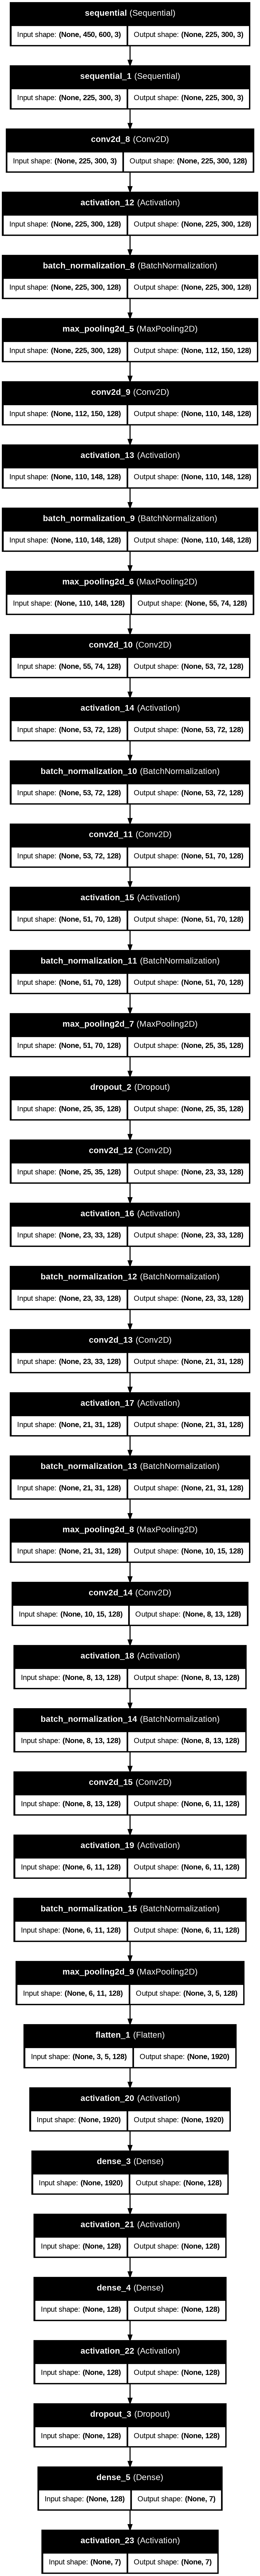

In [ ]:
plot_model(model_scratch_40, to_file='model_scratch_plot.png', show_shapes=True, show_layer_names=True)
# Output hidden for space

In [ ]:
model_scratch_40.evaluate(train)

251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8540 - loss: 0.3623


[0.34888607263565063, 0.8587119579315186]

In [ ]:
model_scratch_40.evaluate(validate)

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.7885 - loss: 0.6149


[0.6008504629135132, 0.7948077917098999]

In [ ]:
model_scratch_40.evaluate(test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.7317 - loss: 0.9374


[0.9562878608703613, 0.7299801707267761]

#V. Transfer Learning Model

After evaluating a variety of architectures to stack on top of the pretrained base model, the simple model below was selected (saved/named here as "transfer_model"). It represents nearly the best accuracy on the testing data, while also displaying minimal signs of overfitting. Several other architectures performed comparably on the test data (even very slightly better) but showed up to a 15% drop in accuracy from training to validation, and again from validation to test datasets. It was also found that training these models beyond 10 epochs produced minimal improvement, and ultimately led to overfitting and reduced performance on the test data.

This model was evaluated both with and without data augmentation, and with and without resizing the iamges from thier original size. It was found that both data augmentation and resizing/rescaling were detrimental to the model's performance.

The results of this model with data augmentation applied are included below for comparison, as are the results of one of the more complex/overfit models.

In [ ]:
# Load the pre-trained ResNet50 model:
base_model_da = ResNet50(weights='imagenet', include_top=False, input_shape=(450, 600, 3))
base_model_da.trainable = False

In [ ]:
# Add additional laters to base model:
transfer_model = Sequential([
    #data_augmentation,
    base_model,
    #resize_and_rescale,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# Compile the model:
transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_1_hist = transfer_model.fit(
        train.repeat(),
        steps_per_epoch=1250,
        epochs=10,
        validation_data=validate.repeat(),
        validation_steps= 250,
        verbose=1,
        callbacks=[
          #EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
          ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1),
          ModelCheckpoint(filepath='/content/tl_1_10.keras', save_best_only=True, monitor='val_loss'),
          TqdmCallback(verbose=1)
        ])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 207s 158ms/step - accuracy: 0.6872 - loss: 0.8943 - val_accuracy: 0.7616 - val_loss: 0.6430 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 191s 153ms/step - accuracy: 0.7474 - loss: 0.6753 - val_accuracy: 0.7847 - val_loss: 0.6150 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 191s 153ms/step - accuracy: 0.7739 - loss: 0.6055 - val_accuracy: 0.7962 - val_loss: 0.5812 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 190s 152ms/step - accuracy: 0.7898 - loss: 0.5554 - val_accuracy: 0.7977 - val_loss: 0.6015 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 191s 153ms/step - accuracy: 0.7953 - loss: 0.5229 - val_accuracy: 0.8007 - val_loss: 0.5695 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 190s 152ms/step - accuracy: 0.8168 - loss: 0.4754 - val_accuracy: 0.8064 - val_loss: 0.5827 - learning_rate: 0.0010
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 190s 152ms

In [25]:
#model_tl_1 = keras.models.load_model('/content/Models_multi/tl_1_10.keras')
model_tl_1 = keras.models.load_model('/content/tl_1_10.keras')

In [ ]:
model_tl_1.evaluate(test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 152ms/step - accuracy: 0.7680 - loss: 0.7710


[0.8169595003128052, 0.7577763199806213]

In [83]:
model_tl_1.evaluate(test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 414ms/step - accuracy: 0.7633 - loss: 0.8064


[0.8169593811035156, 0.7577763199806213]

In [ ]:
model_tl_1.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 15, 19, 2048)        │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,377,239 (92.99 MB)

 Trainable params: 263,175 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 526,352 (2.01 MB)

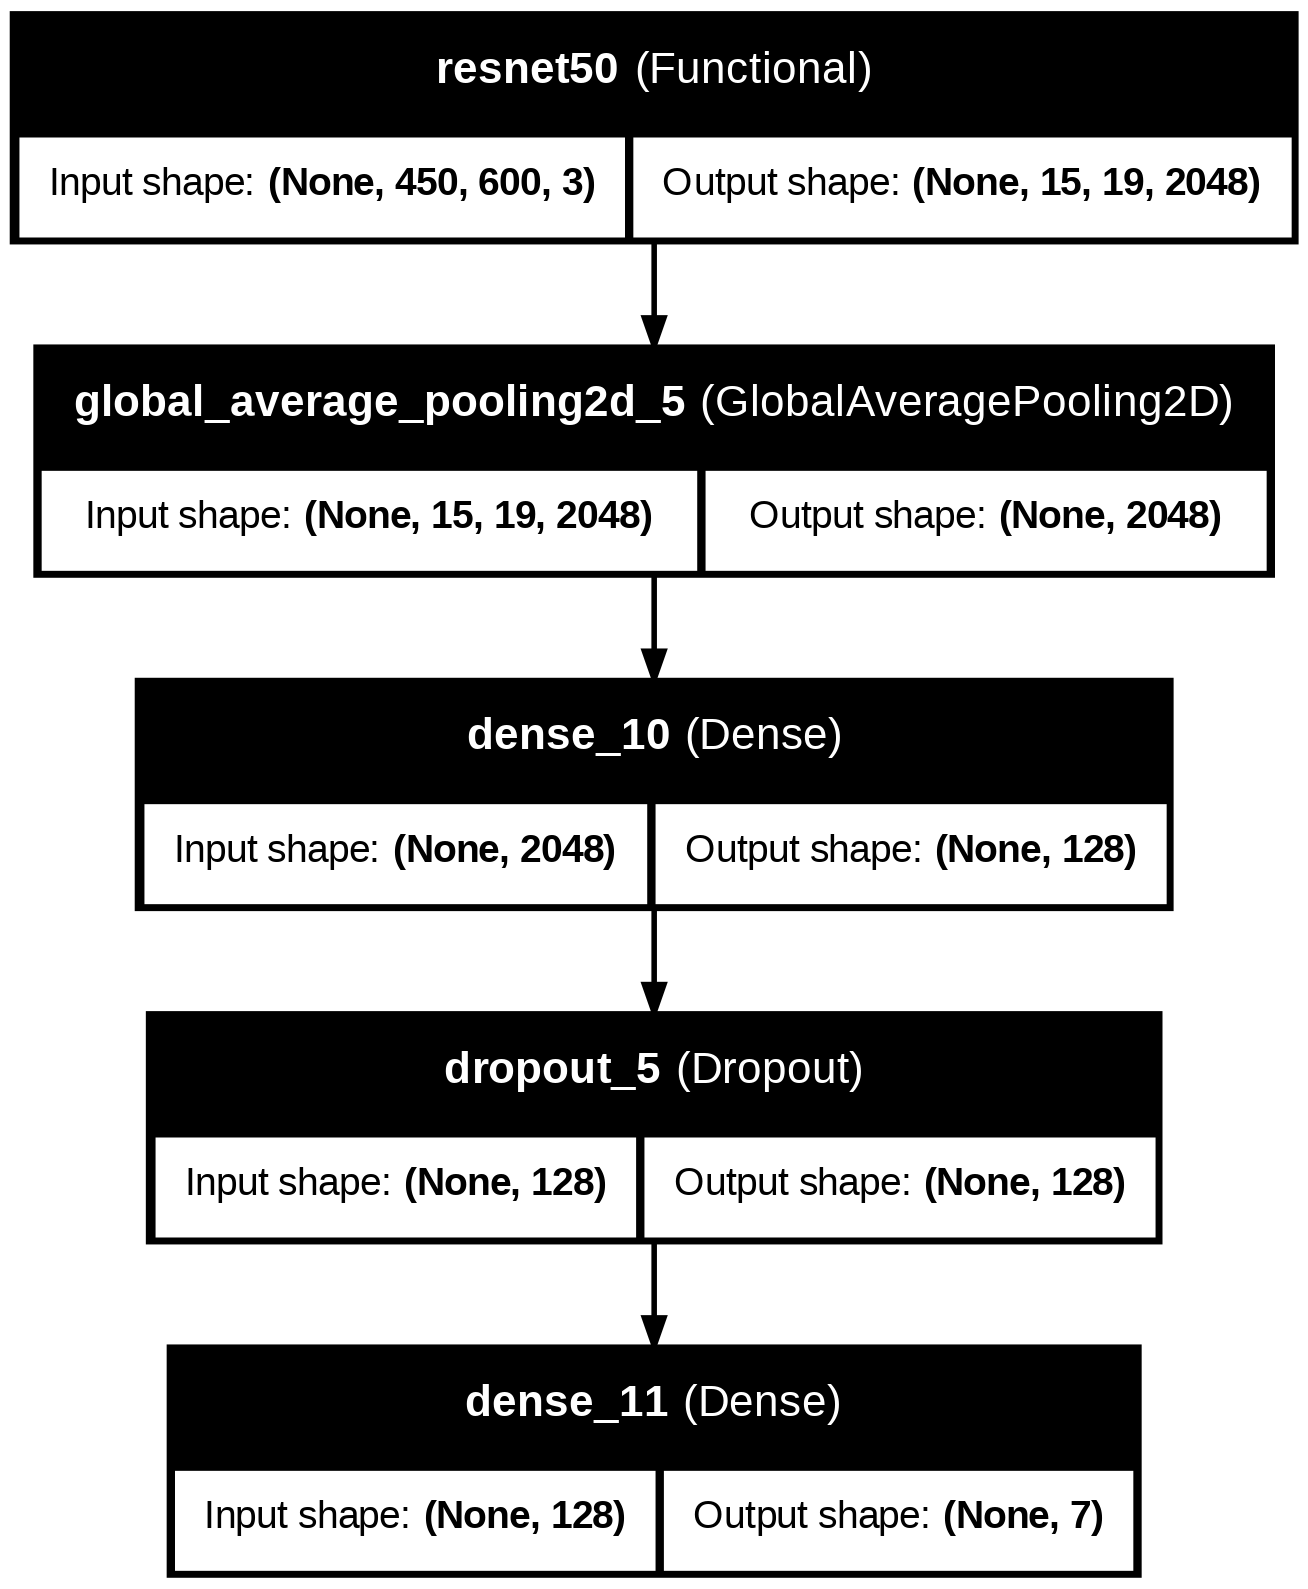

In [ ]:
plot_model(model_tl_1, to_file='tl_model_plot.png', show_shapes=True, show_layer_names=True)

## Example with Data Augmentation

In [ ]:
# get data aug to work:
transfer_model_da = Sequential([
    #resize_and_rescale,
    data_augmentation,
    base_model_da,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# Compile the model:
transfer_model_da.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
transfer_model_da = transfer_model_da.fit(
        train.repeat(),
        steps_per_epoch=1250,
        epochs=10,
        validation_data=validate.repeat(),
        validation_steps= 250,
        verbose=1,
        callbacks=[
          #EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
          ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1),
          ModelCheckpoint(filepath='/content/tl_1_10_da.keras', save_best_only=True, monitor='val_loss'),
          TqdmCallback(verbose=1)
        ])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 309s 239ms/step - accuracy: 0.6870 - loss: 0.8940 - val_accuracy: 0.7386 - val_loss: 0.7261 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 294s 235ms/step - accuracy: 0.7386 - loss: 0.7048 - val_accuracy: 0.7402 - val_loss: 0.7163 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 294s 235ms/step - accuracy: 0.7547 - loss: 0.6642 - val_accuracy: 0.7612 - val_loss: 0.6668 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 293s 235ms/step - accuracy: 0.7622 - loss: 0.6404 - val_accuracy: 0.7742 - val_loss: 0.6560 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 293s 235ms/step - accuracy: 0.7693 - loss: 0.6266 - val_accuracy: 0.7728 - val_loss: 0.6545 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 293s 235ms/step - accuracy: 0.7780 - loss: 0.5967 - val_accuracy: 0.7864 - val_loss: 0.6285 - learning_rate: 0.0010
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 292s 234ms

In [ ]:
transfer_model_da.evaluate(test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.7277 - loss: 0.8452


[0.8645939826965332, 0.7180675268173218]

## Overfitting Example

Below is one of the more extreme examples encountered of overfitting. Despite the use of numerous regularization methods,it shows a loss in accuracy of ~15% from the training to validation datasets, and a loss of another ~14% between validation and test datasets.

This architecture was also evaluated using data augmentation techniques. While this did reduce the severity of overfitting, the overall model performance still did not exceed the other models presented above.

In [ ]:
transfer_model5 = Sequential([
    base_model,

    Conv2D(128, (3, 3), padding = 'same', input_shape=(450, 600, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    #Conv2D(128, (3, 3), padding = 'same', input_shape=(450, 600, 3), activation='relu'),
    #BatchNormalization(),
    #Conv2D(128, (3, 3), padding = 'same', input_shape=(450, 600, 3), activation='relu'),
    #BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    Conv2D(128, (3, 3), padding = 'same', input_shape=(450, 600, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding = 'same', input_shape=(450, 600, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    #Dense(128, activation='relu'),
    #Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

transfer_model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_5_hist = transfer_model5.fit(
        train.repeat(),
        steps_per_epoch=1250,
        epochs=10,
        validation_data=validate.repeat(),
        validation_steps= 250,
        verbose=1, callbacks=[
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1),
            TqdmCallback(verbose=1),
            ModelCheckpoint(filepath='/content/tl_5.keras', save_best_only=True, monitor='val_loss')
            ])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 226s 168ms/step - accuracy: 0.7249 - loss: 0.7858 - val_accuracy: 0.8034 - val_loss: 0.5645 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 197s 158ms/step - accuracy: 0.8688 - loss: 0.3772 - val_accuracy: 0.7840 - val_loss: 0.9430 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 197s 158ms/step - accuracy: 0.9301 - loss: 0.2048 - val_accuracy: 0.8221 - val_loss: 0.7841 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 197s 158ms/step - accuracy: 0.9583 - loss: 0.1238 - val_accuracy: 0.8187 - val_loss: 0.9516 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 197s 158ms/step - accuracy: 0.9711 - loss: 0.0820 - val_accuracy: 0.8234 - val_loss: 1.0668 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9793 - loss: 0.0615
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 197s 158ms/s

In [ ]:
transfer_model5.evaluate(test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.7679 - loss: 0.7124


[0.7664928436279297, 0.7597617506980896]

In [ ]:
transfer_model5_da = Sequential([
    data_augmentation,
    base_model_da,

    Conv2D(128, (3, 3), padding = 'same', input_shape=(450, 600, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    #Conv2D(128, (3, 3), padding = 'same', input_shape=(450, 600, 3), activation='relu'),
    #BatchNormalization(),
    #Conv2D(128, (3, 3), padding = 'same', input_shape=(450, 600, 3), activation='relu'),
    #BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    Conv2D(128, (3, 3), padding = 'same', input_shape=(450, 600, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding = 'same', input_shape=(450, 600, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    #Dense(128, activation='relu'),
    #Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

transfer_model5_da.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_5_hist_da = transfer_model5_da.fit(
        train.repeat(),
        steps_per_epoch=1250,
        epochs=10,
        validation_data=validate.repeat(),
        validation_steps= 250,
        verbose=1, callbacks=[
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1),
            TqdmCallback(verbose=1),
            ModelCheckpoint(filepath='/content/tl_5_da.keras', save_best_only=True, monitor='val_loss')
            ])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 324s 252ms/step - accuracy: 0.7168 - loss: 0.8088 - val_accuracy: 0.7870 - val_loss: 0.6345 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 311s 249ms/step - accuracy: 0.8098 - loss: 0.5325 - val_accuracy: 0.7768 - val_loss: 0.6537 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 312s 250ms/step - accuracy: 0.8347 - loss: 0.4596 - val_accuracy: 0.7908 - val_loss: 0.6311 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 313s 250ms/step - accuracy: 0.8561 - loss: 0.3992 - val_accuracy: 0.7959 - val_loss: 0.6147 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 311s 249ms/step - accuracy: 0.8704 - loss: 0.3619 - val_accuracy: 0.8227 - val_loss: 0.6180 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 311s 249ms/step - accuracy: 0.8828 - loss: 0.3233 - val_accuracy: 0.8128 - val_loss: 0.7127 - learning_rate: 0.0010
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 311s 249ms

In [ ]:
transfer_model5_da.evaluate(test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.7408 - loss: 0.8950


[0.8986690640449524, 0.7385837435722351]

#VI. Additional Evaluation of Performance on Test Data:

Here we take a look at the class probabilities assigned to the observations in the test dataset, and compare them to the ground truth diagnosis.

In application, it is likely that providing a medical professional with class probabilities is more appropriate than a single prediction as a means of providing support to determine a diagnosis.

As demonstrated by the accuracy values broken down by class, as well as the confusion matrices for each model, there is still substantial progress to be made in improving the accuracy of the minority class predictions. Once this is addressed, overall accuiracy of both models should improve significantly.

In [2]:
#model_scratch_40 = keras.models.load_model('/content/Models_multi/from_scratch_40.keras')
model_scratch_40 = keras.models.load_model('/content/from_scratch_40.keras')

In [ ]:
#model_tl_1 = keras.models.load_model('/content/Models_multi/tl_1_10.keras')

In [96]:
# generate predictions for built-from-scratch model:
scratch_predictions = model_scratch_40.predict(test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step


In [138]:
# capture actual Ground Truth labels as a list
actual = []
for images, labels in test:
    for i in range(labels.shape[0]):
        actual.append(labels[i].numpy().argmax(axis=0))

In [141]:
# convert scratch_predictions into dataframe:
scratch_predictions_df = pd.DataFrame(scratch_predictions)
scratch_predictions_df.columns = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
scratch_predictions_df.head()

akiec       bcc       bkl        df       mel        nv          vasc
0  0.345139  0.022378  0.307061  0.000558  0.294088  0.030772  3.477407e-06
1  0.798890  0.001109  0.184958  0.000152  0.014550  0.000342  4.430055e-10
2  0.710251  0.197538  0.047754  0.007229  0.029855  0.007348  2.524100e-05
3  0.132286  0.812774  0.007006  0.014809  0.010237  0.022856  3.263831e-05
4  0.230535  0.570078  0.124048  0.024827  0.019938  0.030355  2.193083e-04

In [142]:
# add predicted and actual classes to scratch_predictions_df:
pred_classes = np.argmax(scratch_predictions, axis=1)

scratch_predictions_df['pred_class'] = pred_classes
dx_names = {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
scratch_predictions_df['dx_pred'] = scratch_predictions_df['pred_class'].apply(lambda x: dx_names[x])
scratch_predictions_df['actual_class'] = actual
scratch_predictions_df['dx_actual'] = scratch_predictions_df['actual_class'].apply(lambda x: dx_names[x])

#scratch_predictions_df['total'] = scratch_predictions_df.iloc[:, 0:7].sum(axis=1)

scratch_predictions_df.head()

akiec       bcc       bkl        df       mel        nv          vasc  \
0  0.345139  0.022378  0.307061  0.000558  0.294088  0.030772  3.477407e-06   
1  0.798890  0.001109  0.184958  0.000152  0.014550  0.000342  4.430055e-10   
2  0.710251  0.197538  0.047754  0.007229  0.029855  0.007348  2.524100e-05   
3  0.132286  0.812774  0.007006  0.014809  0.010237  0.022856  3.263831e-05   
4  0.230535  0.570078  0.124048  0.024827  0.019938  0.030355  2.193083e-04   

   pred_class dx_pred  actual_class dx_actual  
0           0   akiec             0     akiec  
1           0   akiec             0     akiec  
2           0   akiec             0     akiec  
3           1     bcc             0     akiec  
4           1     bcc             0     akiec

In [143]:
# calculate what percentage of the time "dx_pred" matched "dx_actual":
correct = scratch_predictions_df[scratch_predictions_df.dx_pred == scratch_predictions_df.dx_actual].shape[0]
total = scratch_predictions_df.shape[0]
percentage = correct / total * 100
print(percentage)

72.9980145598941


In [ ]:
class_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [178]:
# Calculate the confusion matrix
confusion_matrix_s = confusion_matrix(scratch_predictions_df['actual_class'], scratch_predictions_df['pred_class'])

# Calculate the accuracy for each class
class_accuracies = []
for i in range(len(confusion_matrix_s)):
  class_accuracy = confusion_matrix_s[i][i] / sum(confusion_matrix_s[i])
  class_accuracies.append(class_accuracy)

In [179]:
class_accuracy_df = pd.DataFrame(data={'accuracy': class_accuracies}, index=class_labels)
print(class_accuracy_df.to_string())

       accuracy
akiec  0.348837
bcc    0.505376
bkl    0.516129
df     0.340909
mel    0.432749
nv     0.908590
vasc   0.428571


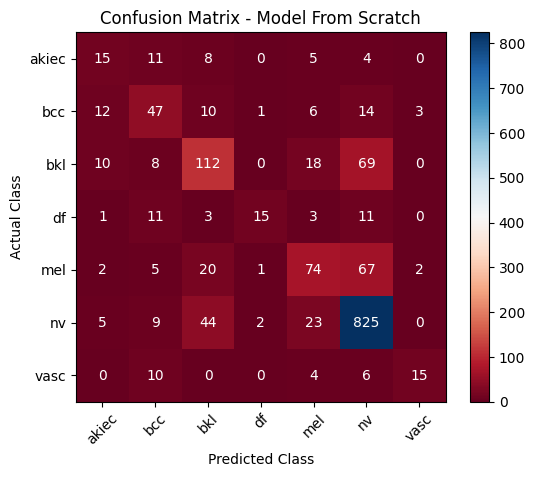

In [181]:
# Plot the confusion matrix
plt.imshow(confusion_matrix_s, interpolation='nearest', cmap=plt.cm.RdBu)
plt.title('Confusion Matrix - Model From Scratch')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Change the font color of the values to black
plt.rcParams['text.color'] = 'black'

# Fill in the matrix with values
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, str(confusion_matrix_s[i][j]), ha='center', va='center', color='white')

plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [149]:
# generate predictions for transfer learning model:
tl_predictions = model_tl_1.predict(test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 399ms/step


In [150]:
# convert tl_predictions into dataframe:
tl_predictions_df = pd.DataFrame(tl_predictions)
tl_predictions_df.columns = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#tl_predictions_df.insert(0, 'image_id', test_metadata['image_id'])
#tl_predictions_df.set_index('image_id', inplace=True)
tl_predictions_df.head()

akiec       bcc       bkl        df       mel        nv          vasc
0  0.399848  0.217544  0.199260  0.068138  0.011374  0.099431  4.405065e-03
1  0.492739  0.001323  0.498005  0.000711  0.007124  0.000098  5.709778e-08
2  0.926023  0.009545  0.056844  0.004873  0.000594  0.002117  4.648331e-06
3  0.342769  0.104534  0.043670  0.041036  0.126368  0.340447  1.175587e-03
4  0.407515  0.301945  0.094472  0.109085  0.036424  0.034328  1.622996e-02

In [151]:
# add predicted and actual classes to scratch_predictions_df:
tl_pred_classes = np.argmax(tl_predictions, axis=1)

tl_predictions_df['pred_class'] = tl_pred_classes
dx_names = {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
tl_predictions_df['dx_pred'] = tl_predictions_df['pred_class'].apply(lambda x: dx_names[x])
tl_predictions_df['actual_class'] = actual
tl_predictions_df['dx_actual'] = tl_predictions_df['actual_class'].apply(lambda x: dx_names[x])

#scratch_predictions_df['total'] = scratch_predictions_df.iloc[:, 0:7].sum(axis=1)

tl_predictions_df.head()

akiec       bcc       bkl        df       mel        nv          vasc  \
0  0.399848  0.217544  0.199260  0.068138  0.011374  0.099431  4.405065e-03   
1  0.492739  0.001323  0.498005  0.000711  0.007124  0.000098  5.709778e-08   
2  0.926023  0.009545  0.056844  0.004873  0.000594  0.002117  4.648331e-06   
3  0.342769  0.104534  0.043670  0.041036  0.126368  0.340447  1.175587e-03   
4  0.407515  0.301945  0.094472  0.109085  0.036424  0.034328  1.622996e-02   

   pred_class dx_pred  actual_class dx_actual  
0           0   akiec             0     akiec  
1           2     bkl             0     akiec  
2           0   akiec             0     akiec  
3           0   akiec             0     akiec  
4           0   akiec             0     akiec

In [174]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Calculate the confusion matrix
confusion_matrix_tl = confusion_matrix(tl_predictions_df['actual_class'], tl_predictions_df['pred_class'])

# Calculate the accuracy for each class
class_accuracies = []
for i in range(len(confusion_matrix_tl)):
  class_accuracy = confusion_matrix_tl[i][i] / sum(confusion_matrix_tl[i])
  class_accuracies.append(class_accuracy)

In [175]:
class_accuracy_df = pd.DataFrame(data={'accuracy': class_accuracies}, index=class_labels)
print(class_accuracy_df.to_string())

       accuracy
akiec  0.558140
bcc    0.430108
bkl    0.714286
df     0.227273
mel    0.473684
nv     0.911894
vasc   0.200000


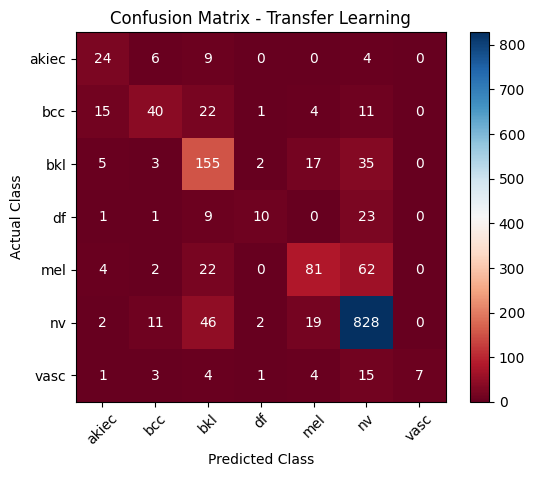

In [182]:
# Plot the confusion matrix
plt.imshow(confusion_matrix_tl, interpolation='nearest', cmap=plt.cm.RdBu)
plt.title('Confusion Matrix - Transfer Learning')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Change the font color of the values to black
plt.rcParams['text.color'] = 'black'

# Fill in the matrix with values
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, str(confusion_matrix_tl[i][j]), ha='center', va='center', color='white')

plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [152]:
# calculate what percentage of the time "dx_pred" matched "dx_actual":
correct = tl_predictions_df[tl_predictions_df.dx_pred == tl_predictions_df.dx_actual].shape[0]
total = tl_predictions_df.shape[0]
percentage = correct / total * 100
print(percentage)

75.77763070814031
